In [1]:
import numpy as np
import matplotlib.pyplot as plt

import stan # pystan3
import arviz as az

import nest_asyncio
nest_asyncio.apply()

# **[Q6] Simple Bayesian Regression with Stan [4+2 pts]**

For this exercise, you will write a probabilistic program in `Stan` that can sample from the posterior $p(\alpha,\beta \,|\, \mathcal{D})$ of a simple (linear) Bayesian regression given a data set $\mathcal{D} = \{x_n,y_n\}_{n=1}^{N}$. The program should represent the following generative specification:
$$\begin{align*}
    \sigma^2 &\sim \text{Inv-Gamma}(1, 1) \\
    \alpha &\sim \mathcal{N}(0, 10) \\
    \beta &\sim \mathcal{N}(0, 10) \\
    y_n &\sim \mathcal{N}\big(\alpha + \beta x_n, \sigma^2\big) \quad\text{ for } n = 1, ..., N
\end{align*}$$
which essentially encodes the assumption that an outcome $y$ is predicted from a covariate $x$ via:
$$y_n = \alpha + \beta x_n + \epsilon_n \;\;\text{ with }\;\; \epsilon_n \sim \mathcal{N}\big(0, \sigma^2\big)$$

First, simulate a data set with fixed intercept ($\alpha$), slope ($\beta$), and noise ($\sigma$) parameters of your choosing, as well as a pre-set number of observations $N$. For instance, your simulation could look something like this:
```
N = 100
alpha = 2.3
sigma = 2.
slope = 4.
x = np.random.normal(size=N)
y = alpha + slope*x + sigma*np.random.normal(size=N)
```

In [2]:
def create_data_dict(N=100, alpha=2.3, sigma=2.0, slope=4.0):
    # Simulate data
    x = np.random.normal(size=N)
    y = alpha + slope*x + sigma*np.random.normal(size=N)
    
    # Create Stan-friendly data dictionary
    data_dict = {
        'N': N,
        'x': x,
        'y': y
    }

    return data_dict

In [3]:
stan_code = """
data {
    int<lower=1> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors 
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);
    sigma2 ~ inv_gamma(1, 1);

    // Likelihood
    y ~ normal(alpha + beta*x, sigma);
}
"""

## **[4 pts]** Then, pass the data to your program, inspect convergence and efficiency diagnostics, and summarize your inferential results both numerically and graphically. How accurate are the posterior means and how much uncertainty is left?

In [4]:
data_dict_A = create_data_dict() # N=100
stan_model_A = stan.build(stan_code, data=data_dict_A)
#Building: 23.5s, 24.2s, 24.7s

Building: found in cache, done.


In [5]:
%%time
fit_A = stan_model_A.sample(num_chains=4, num_samples=2500, num_warmup=1000) # `diffusion_stan.ipynb`

Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!


CPU times: user 343 ms, sys: 177 ms, total: 519 ms
Wall time: 788 ms


In [6]:
# Posterior summary statistics
az.summary(fit_A)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.168,0.195,1.811,2.541,0.002,0.001,8860.0,6936.0,1.0
beta,3.943,0.198,3.568,4.319,0.002,0.002,8608.0,6628.0,1.0
sigma2,3.726,0.543,2.814,4.796,0.006,0.004,8141.0,6383.0,1.0
sigma,1.925,0.139,1.678,2.190,0.002,0.001,8141.0,6383.0,1.0


**Inspect convergence and efficiency diagnostics.**
- Convergence: Since `r_hat` equals 1.0 for each parameter, this suggests that the model converged well. (want $\texttt{r\_hat} < 1.05$)
- Efficiency: `ess_bulk` and `ess_tail` are both well above 100 for all parameters, which suggests that the model sampled efficiently.

**How accurate are the posterior means and how much uncertainty is left?**
- **$\alpha$ (intercept):** The posterior mean is $2.168$ with a SD (standard deviation) of $0.195$. Compared to the fixed value ($\alpha = 2.3$), the mean is lower but is still within a SD. The fixed value is also within the 94% HDI (highest density interval) of $1.811$ to $2.541$.
- **$\beta$ (slope):** The posterior mean is $3.943$ with a SD of $0.198$. Compared to the fixed value ($\beta = 4.0$), the mean is only slightly lower (well within a SD). The fixed value is also within the 94% HDI of $3.568$ to $4.319$.
- **$\sigma$ (noise):** The posterior mean is $1.925$ with a SD of $0.139$. Compared to the fixed value ($\sigma = 2.0$), the mean is only slightly lower (well within a SD). The fixed value is also within the 94% HDI of $1.678$ to $2.190$.

From the above observations, we can conclude that the model estimate is reasonably accurate with relatively low uncertainty for each parameter.

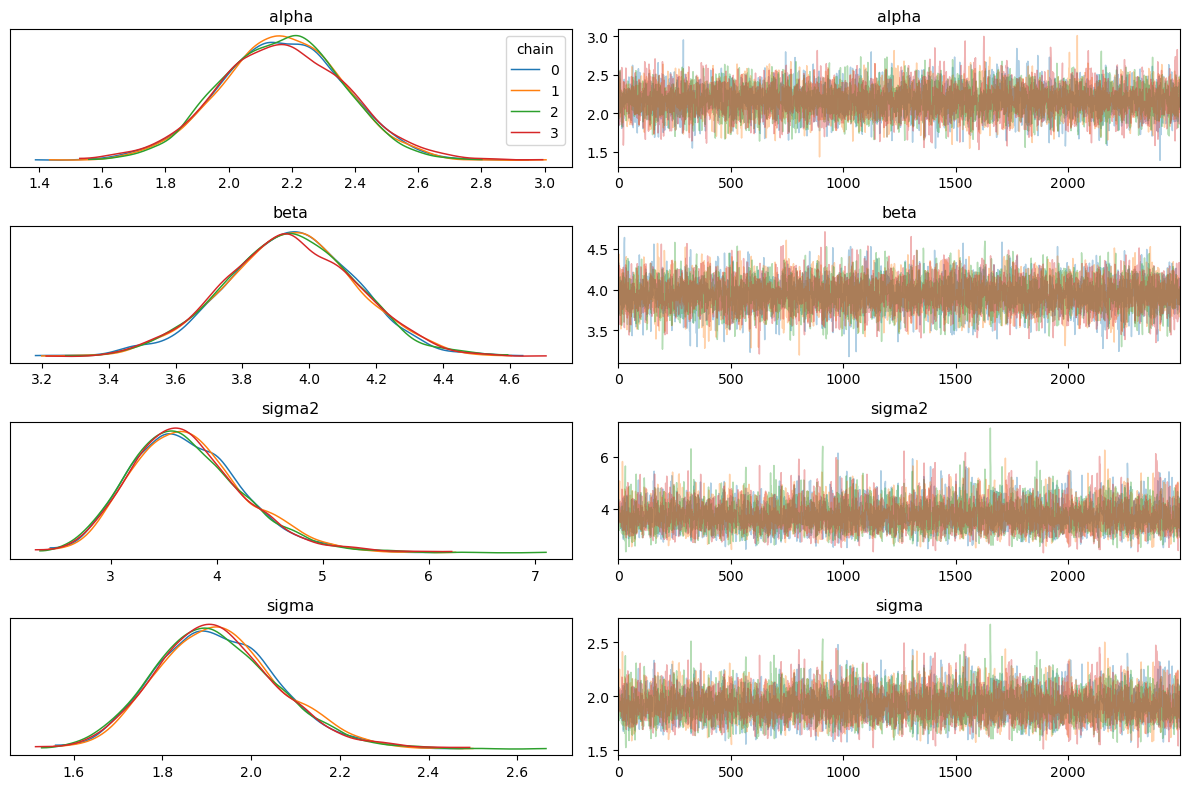

In [7]:
# Traceplots
f_A = az.plot_trace(fit_A, compact=False, legend=True)
plt.tight_layout()

## **[2 pts]** Repeat the analysis with 10 times as many observations and report what happens to the precision and uncertainty.

In [8]:
data_dict_B = create_data_dict(N=1000)
stan_model_B = stan.build(stan_code, data=data_dict_B)

Building: found in cache, done.


In [9]:
%%time
fit_B = stan_model_B.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000137 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
  Adjust your expectations accordingly!


CPU times: user 478 ms, sys: 85.3 ms, total: 563 ms
Wall time: 1.74 s


In [10]:
# Posterior summary statistics
az.summary(fit_B)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.332,0.063,2.209,2.446,0.001,0.000,9594.0,7579.0,1.0
beta,4.026,0.063,3.904,4.141,0.001,0.000,10231.0,7307.0,1.0
sigma2,3.965,0.176,3.642,4.299,0.002,0.001,9671.0,7229.0,1.0
sigma,1.991,0.044,1.908,2.073,0.000,0.000,9671.0,7229.0,1.0


**Report what happens to the precision and uncertainty.**

Compared to the first model, the precision is much better (all parameters are closer to the fixed values than the 1st model) and the uncertainty is lower (the SDs for all of the parameters are lower than 1st model).

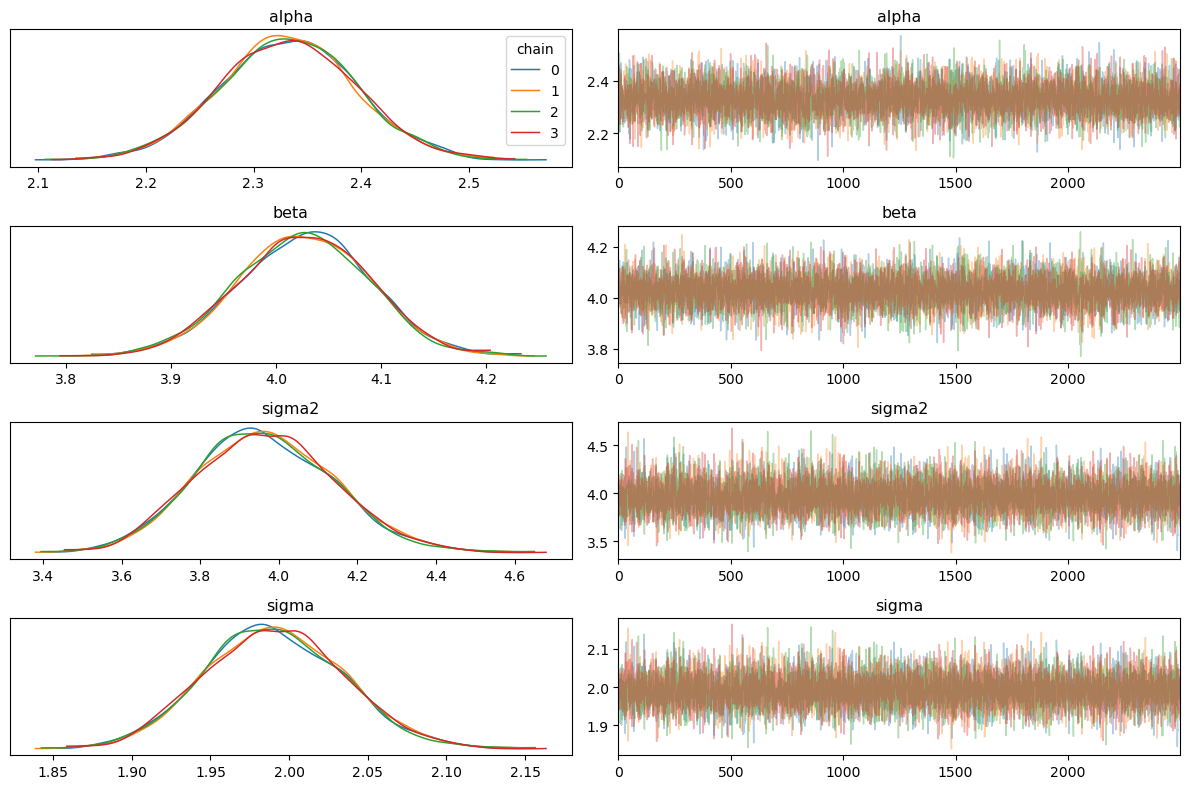

In [11]:
# Traceplots
f_B = az.plot_trace(fit_B, compact=False, legend=True)
plt.tight_layout()